In [3]:
import os
import datetime
import glob
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from pymongo import MongoClient
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
mongo_name = ['Australia', 'Bahrain', 'Brazil', 'Brunei',
              'Cambodia','Canada', 'Hong Kong',
                'China', 'Czech', 'Denmark', 'Euro',
                'Fiji', 'Hungary', 'India', 'Indonesia',
                'Israel',
                'Japan', 'Jordan', 'Kuwait', 'Malaysia',
                'Mexico', 'New Zealand',
                'Norway', 'Philippines', 'Poland', 'Russia',
                'Saudi Arabia', 'Singapore', 'South Africa',
                'Sweden', 'Switzerland', 'Taiwan', 'Thailand',
                'Turkey', 'UAE', 'UK', 'USA', 'Vietnam']

class preprocess():
    def __init__(self):
        self.client = MongoClient('localhost', 27017)
        self.db_ex = self.client['exchange']
        self.db_int = self.client['interest']
        self.db_inf = self.client['inflation']
        self.db_m1 = self.client['liquidity']
        
    def monthly_preprocessing(self, country):
        ex_ca = pd.DataFrame(list(self.db_ex[country].find({}, {'_id':0})))
        ex_ca['date'] = pd.to_datetime(ex_ca['date'])
        ex_ca = ex_ca.set_index('date')
        ex_ca['ex'] = np.log(ex_ca['buy'])
        ex_ca = ex_ca.resample(rule = 'M').last()
        
        df = ex_ca.reset_index()[['date','ex']]
        coll_int = self.db_int[country]
        inter = pd.DataFrame(list(coll_int.find({}, {'_id':0})))
        if '1' in inter.columns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea1Y'].find({}, {'_id':0})))
            interest = pd.merge(inter, int_ko, on='date', how='inner')
            interest['int_spread'] = interest['interest1Y_y'] - interest['interest1Y_x'] 
            interest['date'] = pd.to_datetime(interest['date'])
            interest = interest[['date', 'int_spread']]

            df = pd.merge(df, interest, on='date', how = 'inner')
            df['date'] = df['date'].dt.strftime("%Y-%m")
        elif '2' in inter.colunns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea2Y'].find({}, {'_id':0})))
            interest = pd.merge(inter, int_ko, on='date', how='inner')
            interest['int_spread'] = interest['interest1Y_y'] - interest['interest1Y_x'] 
            interest['date'] = pd.to_datetime(interest['date'])
            interest = interest[['date', 'int_spread']]

            df = pd.merge(df, interest, on='date', how = 'inner')
            df['date'] = df['date'].dt.strftime("%Y-%m")
        elif len(inter) == 0:
            pass

        inf = pd.DataFrame(list(self.db_inf[country + 'M'].find({}, {'_id':0})))
        infq = pd.DataFrame(list(self.db_inf[country + 'Q'].find({}, {'_id':0})))
        inflation_KOR = pd.DataFrame(list(self.db_inf['Korea' + 'M'].find({}, {'_id':0})))
        if len(inf) != 0:
            inf['inf_c'] = inf['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(inf, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) != 0:
            infq['date'] = pd.to_datetime(infq['date']).dt.to_period('Q')
            infq = infq.set_index('date').astype('float')
            infq = infq.resample(rule = 'M').fillna(method= 'ffill')
            infq = infq.reset_index()
            infq['date'] = infq['date'].astype('str')
            infq['inf_c'] = infq['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(infq, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) == 0:
            pass

        
        m1 = pd.DataFrame(list(self.db_m1[country + 'M'].find({}, {'_id':0})))
        m1q = pd.DataFrame(list(self.db_m1[country + 'Q'].find({}, {'_id':0})))
        if len(m1) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1['m1'] = np.log(m1['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1 = pd.merge(m1[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1['m1_spread'] = m1['m1_k'] - m1['m1']
            df = pd.merge(df, m1[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1q['date'] = pd.to_datetime(m1q['date']).dt.to_period('Q')
            m1q = m1q.set_index('date').astype('float')
            m1q = m1q.resample(rule = 'M').fillna(method= 'ffill')
            m1q = m1q.reset_index()
            m1q['date'] = m1q['date'].astype('str')
            m1q['m1'] = np.log(m1q['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1q = pd.merge(m1q[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1q['m1_spread'] = m1q['m1_k'] - m1q['m1']
            df = pd.merge(df, m1q[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) == 0:
            pass
        
        date_time = pd.to_datetime(df.pop('date'), format='%Y-%m')
        df = df.astype('float')
        
        return df, date_time
    
    def daily_preprocessing(self, country):
        ex_ca = pd.DataFrame(list(self.db_ex[country].find({}, {'_id':0})))
        ex_ca['date'] = pd.to_datetime(ex_ca['date'])
        ex_ca['ex'] = np.log(ex_ca['buy'])
        df = ex_ca[['date','ex']]
        
        coll_int = self.db_int[country]
        inter = pd.DataFrame(list(coll_int.find({}, {'_id':0})))
        if '1' in inter.columns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea1Y'].find({}, {'_id':0})))
        elif '2' in inter.colunns[1]:
            int_ko = pd.DataFrame(list(self.db_int['Korea2Y'].find({}, {'_id':0})))

        interest = pd.merge(inter, int_ko, on='date', how='inner')
        interest['int_spread'] = interest['interest1Y_y'] - interest['interest1Y_x'] 
        interest['date'] = pd.to_datetime(interest['date'])
        interest = interest[['date', 'int_spread']]

        df = pd.merge(df, interest, on='date', how = 'inner')
        
        inf = pd.DataFrame(list(self.db_inf[country + 'M'].find({}, {'_id':0})))
        infq = pd.DataFrame(list(self.db_inf[country + 'Q'].find({}, {'_id':0})))
        inflation_KOR = pd.DataFrame(list(self.db_inf['Korea' + 'M'].find({}, {'_id':0})))
        
        if len(inf) != 0:
            inf['inf_c'] = inf['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(inf, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            inflation['date'] = pd.to_datetime(inflation['date']).dt.to_period('M')
            inflation = inflation.set_index('date')
            inflation = inflation.resample(rule = 'D').fillna(method= 'ffill')
            inflation = inflation.reset_index()
            inflation['date'] = pd.to_datetime(inflation['date'].astype('str'))
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) != 0:
            infq['date'] = pd.to_datetime(infq['date']).dt.to_period('Q')
            infq = infq.set_index('date').astype('float')
            infq = infq.resample(rule = 'M').fillna(method= 'ffill')
            infq = infq.reset_index()
            infq['date'] = infq['date'].astype('str')
            infq['inf_c'] = infq['inflation'].astype('float').pct_change()*100
            inflation_KOR['inf_kc'] = inflation_KOR['inflation'].astype('float').pct_change()*100
            inflation = pd.merge(infq, inflation_KOR[['date', 'inf_kc']], on='date', how='inner' )
            inflation['inf_spread'] = inflation['inf_kc'] - inflation['inf_c']
            inflation['date'] = pd.to_datetime(inflation['date']).dt.to_period('M')
            inflation = inflation.set_index('date')
            inflation = inflation.resample(rule = 'D').fillna(method= 'ffill')
            inflation = inflation.reset_index()
            inflation['date'] = pd.to_datetime(inflation['date'].astype('str'))
            df = pd.merge(df, inflation[['date', 'inf_spread']], on='date', how = 'inner')
        elif len(inf) == 0 and len(infq) == 0:
            pass
        
        m1 = pd.DataFrame(list(self.db_m1[country + 'M'].find({}, {'_id':0})))
        m1q = pd.DataFrame(list(self.db_m1[country + 'Q'].find({}, {'_id':0})))
        if len(m1) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1['m1'] = np.log(m1['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1 = pd.merge(m1[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1['m1_spread'] = m1['m1_k'] - m1['m1']
            m1['date'] = pd.to_datetime(m1['date']).dt.to_period('M')
            m1 = m1.set_index('date')
            m1 = m1.resample(rule = 'D').fillna(method= 'ffill')
            m1 = m1.reset_index()
            m1['date'] = pd.to_datetime(m1['date'].astype('str'))
            df = pd.merge(df, m1[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) != 0:
            m1_KOR = pd.DataFrame(list(self.db_m1['Korea' + 'M'].find({}, {'_id':0})))
            m1q['date'] = pd.to_datetime(m1q['date']).dt.to_period('Q')
            m1q = m1q.set_index('date').astype('float')
            m1q = m1q.resample(rule = 'M').fillna(method= 'ffill')
            m1q = m1q.reset_index()
            m1q['date'] = m1q['date'].astype('str')
            m1q['m1'] = np.log(m1q['liquidity'].astype('float'))
            m1_KOR['m1_k'] = np.log(m1_KOR['liquidity'].astype('float'))
            m1q = pd.merge(m1q[['date','m1']], m1_KOR[['date', 'm1_k']], on='date', how='inner')
            m1q['m1_spread'] = m1q['m1_k'] - m1q['m1']
            m1q['date'] = pd.to_datetime(m1q['date']).dt.to_period('M')
            m1q = m1q.set_index('date')
            m1q = m1q.resample(rule = 'D').fillna(method= 'ffill')
            m1q = m1q.reset_index()
            m1q['date'] = pd.to_datetime(m1q['date'].astype('str'))
            df = pd.merge(df, m1q[['date', 'm1_spread']], on='date', how = 'inner')
        elif len(m1) == 0 and len(m1q) == 0:
            pass
        
        date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')
        df = df.astype('float')
        
        return df, date_time

In [5]:
pre = preprocess()
df, date_time = pre.monthly_preprocessing('Canada')

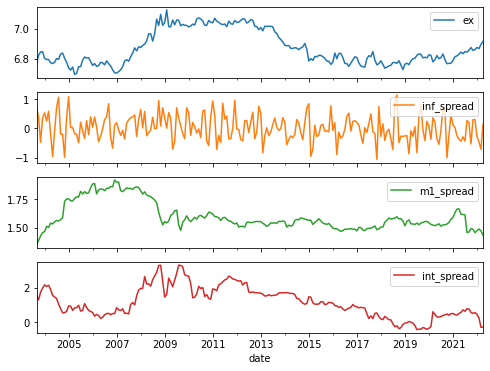

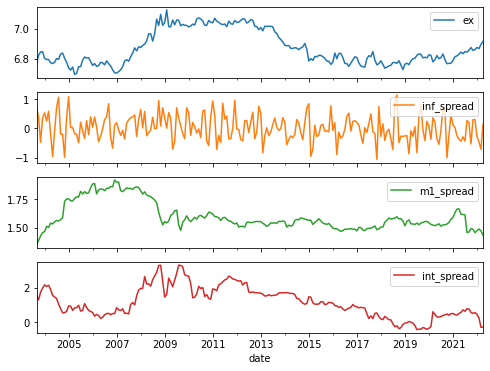

In [6]:
plot_cols = ['ex', 'inf_spread', 'm1_spread', 'int_spread']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ex,224.0,6.869257,0.112780,6.695008,6.779711,6.826680,7.008698,7.125500
int_spread,224.0,1.157138,0.871860,-0.414000,0.510000,1.039000,1.716250,3.300000
inf_spread,224.0,0.022087,0.440465,-1.049890,-0.268934,-0.013661,0.324402,1.135684
m1_spread,224.0,1.599335,0.122992,1.351762,1.522085,1.556812,1.620439,1.920800


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
column_indices, num_features

({'ex': 0, 'int_spread': 1, 'inf_spread': 2, 'm1_spread': 3}, 4)

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

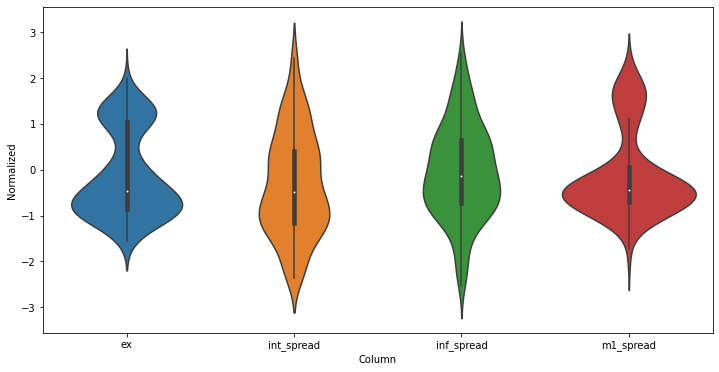

In [10]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys())

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [12]:
w1 = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                     input_width=25, label_width=1, shift=25,
                     label_columns=['ex'])
w1

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [49]
Label column name(s): ['ex']

In [17]:
w2 = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                     input_width=5, label_width=1, shift=1,
                     label_columns=['ex'])
w2

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['ex']

In [18]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] 
             for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[50:50+w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 6, 4)
Inputs shape: (3, 5, 4)
Labels shape: (3, 1, 1)


In [23]:
w2.example = example_inputs, example_labels

In [28]:
def plot(self, model=None, plot_col='ex', max_subplots=3):
    print(self.example)
    print('다음')
    inputs, labels = self.example
    print(inputs)
    print('다음')
    print(labels)
    print('다음')
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    print(plot_col)
    print('다음')
    print(plot_col_index)
    print('다음')
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        print(self.input_indices)
        print('다음')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

(<tf.Tensor: shape=(3, 5, 4), dtype=float64, numpy=
array([[[-0.96114354,  0.18366827,  1.55108367, -1.9943452 ],
        [-0.51192619, -0.13933555,  0.77973689, -1.72651456],
        [-0.32842765,  0.42915117, -1.19641837, -1.41806922],
        [-0.31155228,  0.73923484,  0.71984338, -1.20364965],
        [-0.6819284 ,  0.97179758,  1.12652944, -1.12309192]],

       [[-0.26578203,  0.17074812, -0.72730834,  1.87545342],
        [-0.03825158,  0.584193  ,  0.56998064,  1.84237198],
        [-0.07402704,  0.71339453,  1.40473351,  1.61816229],
        [ 0.0368186 ,  0.70047438, -0.05897304,  1.39278391],
        [ 0.11071237,  1.59196491,  1.23855384,  1.54533317]],

       [[ 1.30636932,  1.30772155, -0.14038381, -0.5494864 ],
        [ 1.33044614,  1.25604094, -0.18341905, -0.8238917 ],
        [ 1.42276717,  1.28188125, -0.99563964, -0.77225146],
        [ 1.51917046,  0.95887743, -1.08059687, -0.77266184],
        [ 1.49031008,  1.13329949,  0.50500079, -0.82646604]]])>, <tf.Tensor

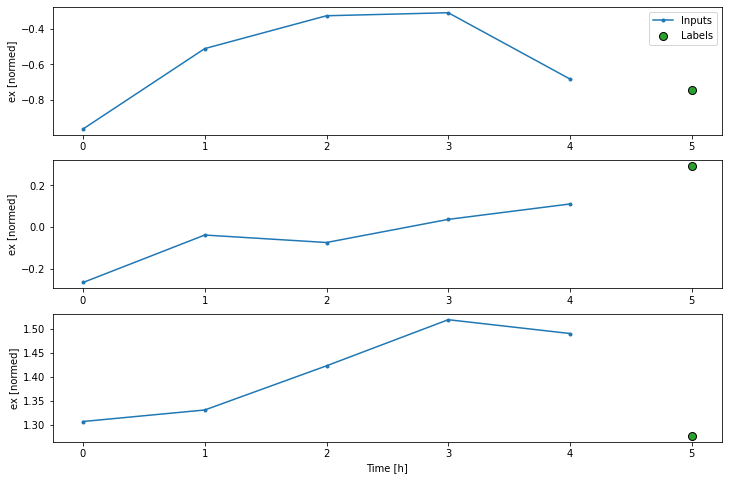

In [29]:
w2.plot()

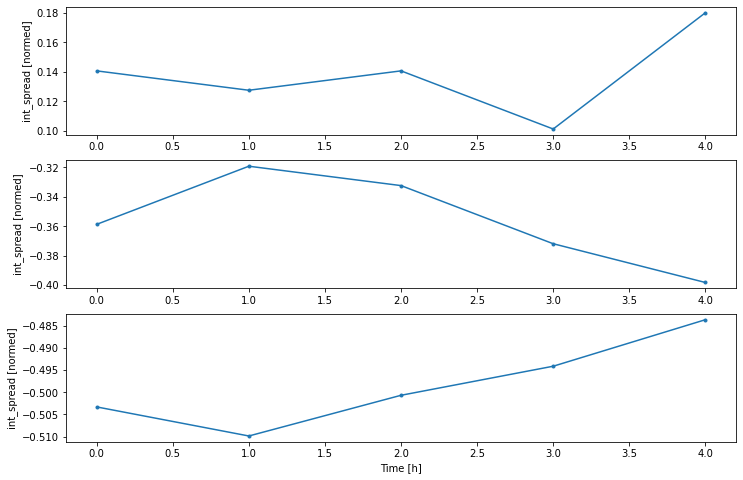

In [232]:
w2.plot(plot_col='int_spread')

In [233]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=25,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [234]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [235]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 5, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [236]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (25, 5, 4)
Labels shape (batch, time, features): (25, 1, 1)


In [244]:
val_performance = {}
performance = {}
MAX_EPOCHS = 300

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [238]:
CONV_WIDTH = 5
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ex'])

conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['ex']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

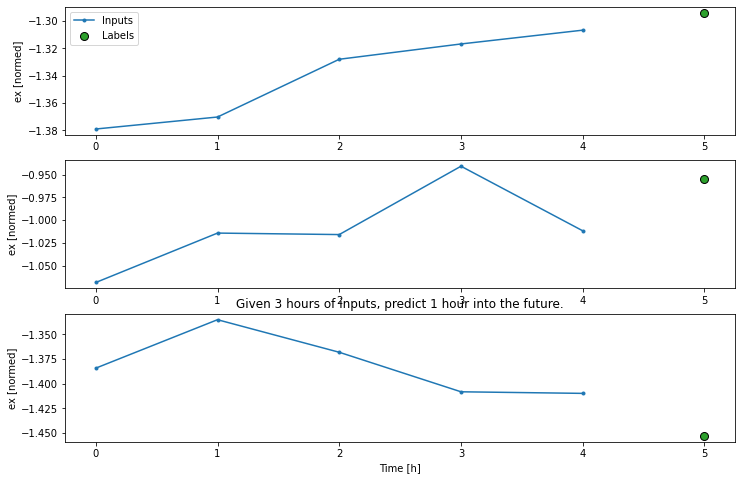

In [239]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [240]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=1),
])

In [241]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (25, 5, 4)
Output shape: (25, 1, 1)


In [242]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

19/19 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0371


In [245]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (25, 50, 4)
Labels shape: (25, 50, 4)
Output shape: (25, 46, 1)


In [246]:
LABEL_WIDTH = 5
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ex'])

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [5 6 7 8 9]
Label column name(s): ['ex']

In [247]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (25, 9, 4)
Labels shape: (25, 5, 1)
Output shape: (25, 5, 1)


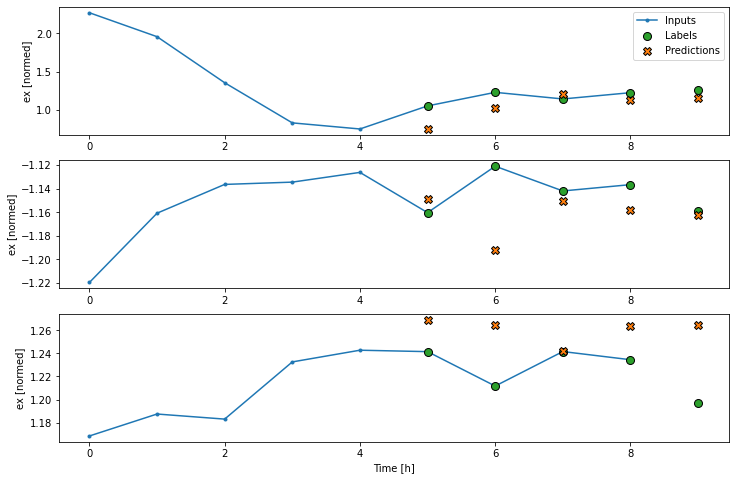

In [248]:
wide_conv_window.plot(conv_model)

In [249]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [250]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (25, 50, 4)
Output shape: (25, 50, 1)


In [251]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

17/17 [==============================] - 0s 16ms/step - loss: 0.7866 - mean_absolute_error: 0.6736


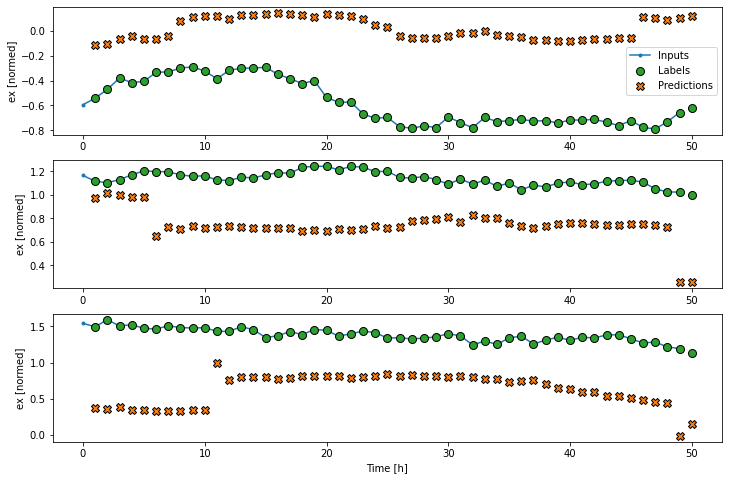

In [252]:
wide_window.plot(lstm_model)

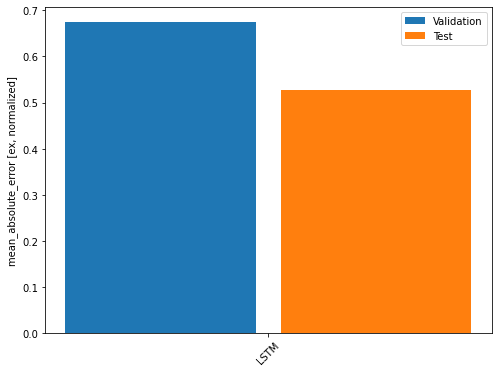

In [253]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [ex, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [254]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.5277


In [255]:
wide_window = WindowGenerator(
    input_width=25, label_width=25, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (25, 25, 4)
Labels shape (batch, time, features): (25, 25, 4)


In [256]:
val_performance = {}
performance = {}

In [257]:
%%time
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

17/17 [==============================] - 0s 10ms/step - loss: 0.0396 - mean_absolute_error: 0.0754

CPU times: user 1min 1s, sys: 22.5 s, total: 1min 24s
Wall time: 1min 12s


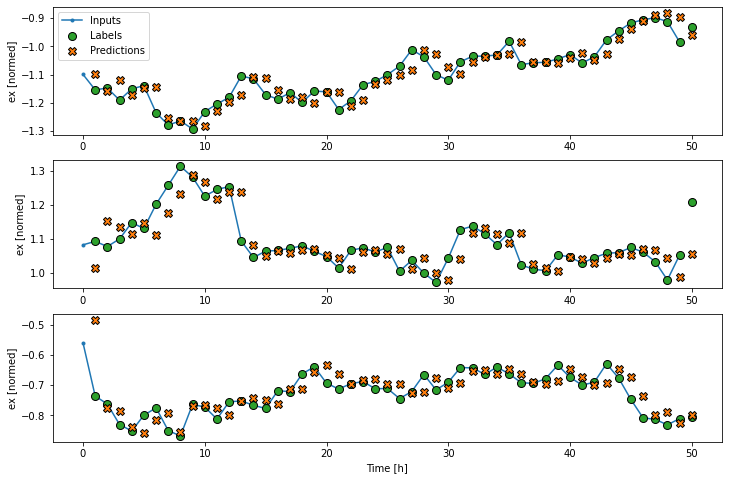

In [258]:
wide_window.plot(lstm_model)

In [259]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
        return inputs + delta

In [260]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32,activation='tanh', return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

17/17 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_absolute_error: 0.0597

CPU times: user 9.2 s, sys: 2.92 s, total: 12.1 s
Wall time: 10.2 s


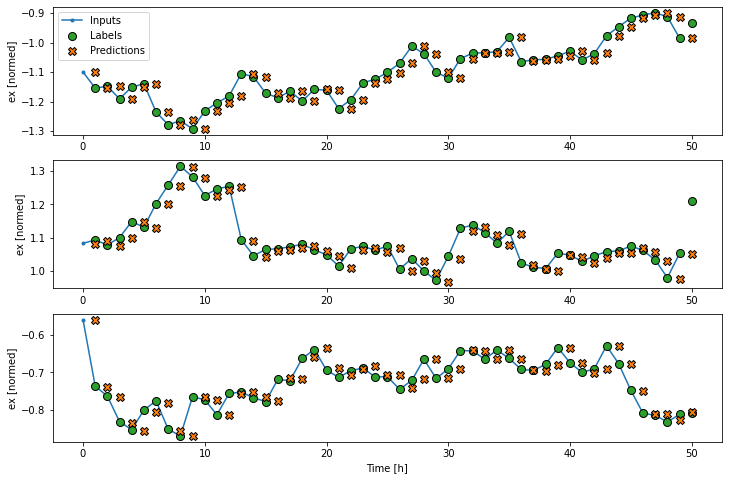

In [261]:
wide_window.plot(residual_lstm)

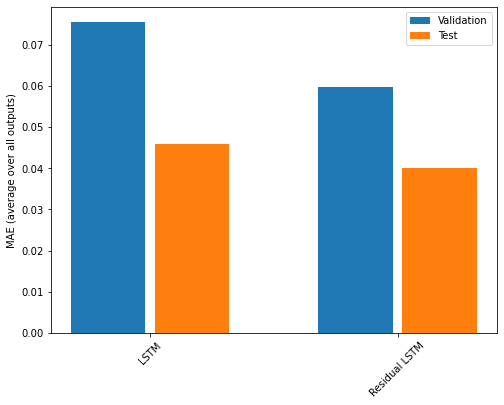

In [262]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [263]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

LSTM           : 0.0458
Residual LSTM  : 0.0400


Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): None

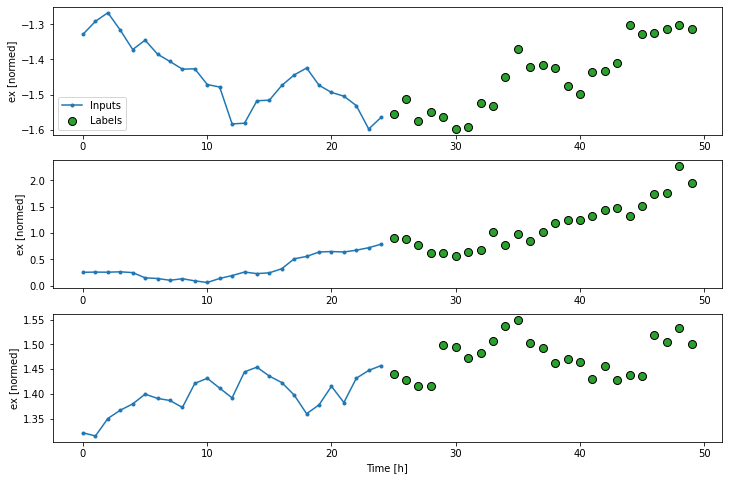

In [264]:
multi_val_performance = {}
multi_performance = {}
OUT_STEPS = 25
multi_window = WindowGenerator(input_width=25,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

17/17 [==============================] - 0s 6ms/step - loss: 0.4213 - mean_absolute_error: 0.4263


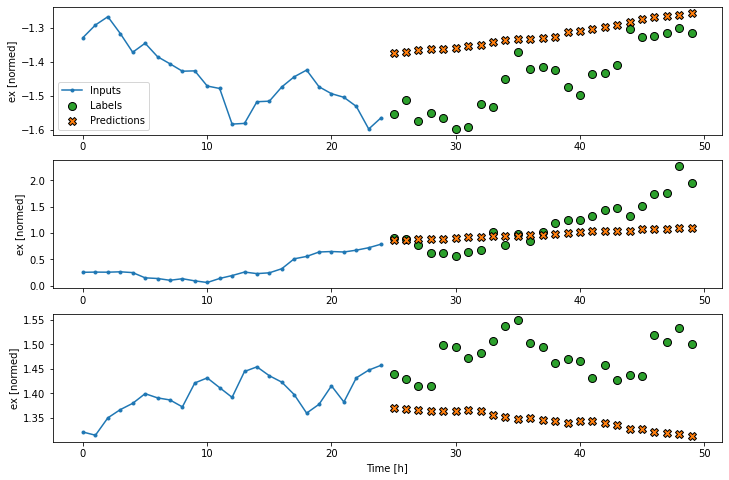

In [265]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [266]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)

        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [267]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [268]:
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)

    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [269]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([25, 4])

In [270]:
def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)

    predictions.append(prediction)

    for n in range(1, self.out_steps):
        x = prediction
        x, state = self.lstm_cell(x, states=state,
                              training=training)
        prediction = self.dense(x)
        predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [271]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (25, 25, 4)


17/17 [==============================] - 1s 68ms/step - loss: 0.3679 - mean_absolute_error: 0.4356


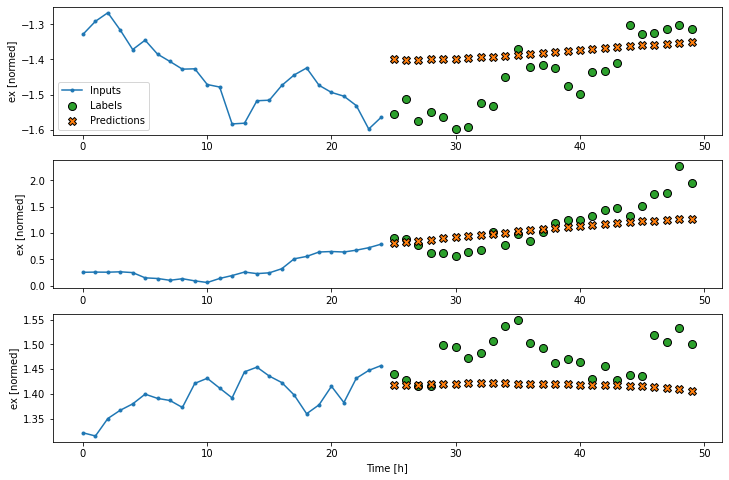

In [272]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

17/17 [==============================] - 0s 5ms/step - loss: 0.2317 - mean_absolute_error: 0.2852


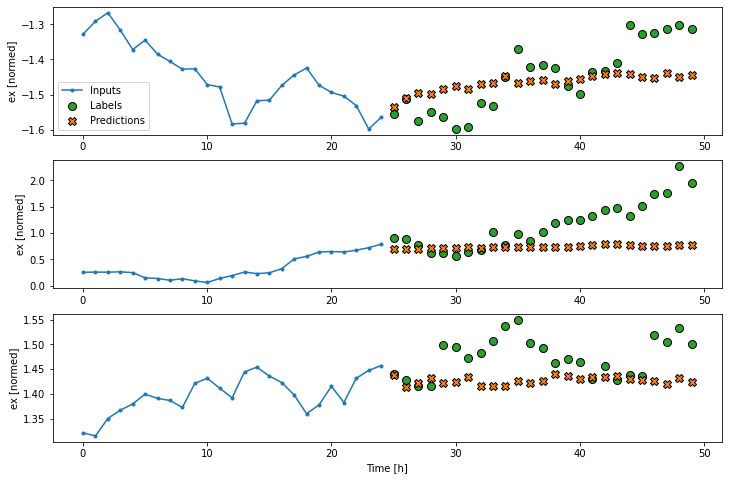

In [273]:
CONV_WIDTH = 5
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='tanh', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

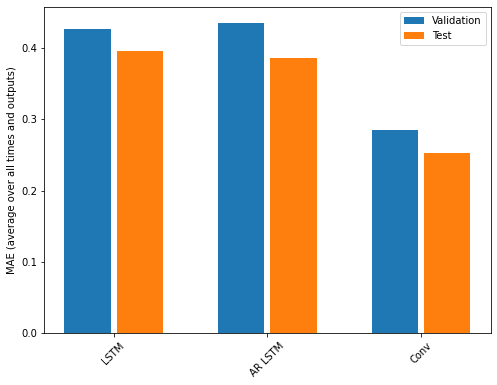

In [274]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [275]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

LSTM    : 0.3955
AR LSTM : 0.3861
Conv    : 0.2530
